##  Covid Image Classification Using ResNet and Inference
COVID-19 detection models utilizing CT images involve the application of machine learning algorithms to analyze chest X-ray images, aiming to identify patterns and features associated with COVID-19 infections. The provided [dataset](https://www.kaggle.com/datasets/plameneduardo/a-covid-multiclass-dataset-of-ct-scans/) comprises 4173 CT scan images of the lungs (Chest CT Scan) with three different classes, including Covid, Healthy, and Others. Our focus for this assignment is solely on the first two classes.*italicized text*

### Download the Dataset

You can download the dataset of this relevant exercise using the code snippet below. Just note that you need to create an account in Kaggle first and then follow the steps below to receive your `kaggle.json` file and then upload it below:
1. Go to your Kaggle account, Scroll to the API section, and Click Expire API Token to remove previous tokens
2. Click on Create New API Token - It will download the `kaggle.json` file on your machine.

If you need more details to read, you can refer to this [link](https://www.kaggle.com/discussions/general/156610).


In [1]:
from google.colab import files

In [2]:
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mohammadhsameti","key":"bd94174957e5a77decc6fe7f9e09f4ff"}'}

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download plameneduardo/a-covid-multiclass-dataset-of-ct-scans/

 97% 393M/405M [00:04<00:00, 99.2MB/s]
100% 405M/405M [00:04<00:00, 98.1MB/s]


In [5]:
!unzip ./a-covid-multiclass-dataset-of-ct-scans.zip

Archive:  ./a-covid-multiclass-dataset-of-ct-scans.zip
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132320.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132449.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132516.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132540.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132608.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132636.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132704.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132740.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132814.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132844.png  
  inflating: New_Data_CoV2/Covid/Patient (10)/AnotaтАб╓╢o 2020-04-28 132926.png  
  inflating: New_Data_CoV2/Covid/Patient (1

### Preprocessing

* The existing data structure consists of patient-wise subfolders. Thus, the initial step involves copying all images into the Covid, Healthy, and Other folders while eliminating any subfolders.

* Count the data in each class to determine if there is an imbalance issue or not.

In [6]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import cv2
import numpy as np
from sklearn import utils
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD
import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

 Creating ./data with its subfolders, splitting the files, and saving each file to its respective directory.

In [7]:
!mkdir ./data
!mkdir ./data/train
!mkdir ./data/test
!mkdir ./data/train/covid
!mkdir ./data/train/healthy
!mkdir ./data/test/covid
!mkdir ./data/test/healthy

In [8]:
def copyfiles(source, dest):
    file_names = []
    for foldername, subfolders, filenames in os.walk(source):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            file_names.append(file_path)

    train_files, test_files = train_test_split(file_names, test_size=0.2, random_state=42)
    for file_path in train_files:
        shutil.copy(file_path, os.path.join('./data/train' + dest, os.path.basename(file_path)))
    for file_path in test_files:
        shutil.copy(file_path, os.path.join('./data/test' + dest, os.path.basename(file_path)))

copyfiles('./New_Data_CoV2/Covid', '/covid')
copyfiles('./New_Data_CoV2/Healthy', '/healthy')

In [9]:
def count_files(directory_path):
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

print('The total number of files in trainset:',  count_files('./data/train/'))
print('The total number of files in testset:',  count_files('./data/test/'))

The total number of files in trainset: 2065
The total number of files in testset: 530


Visualize the dataset and plot some randomly selected sample images from the data.

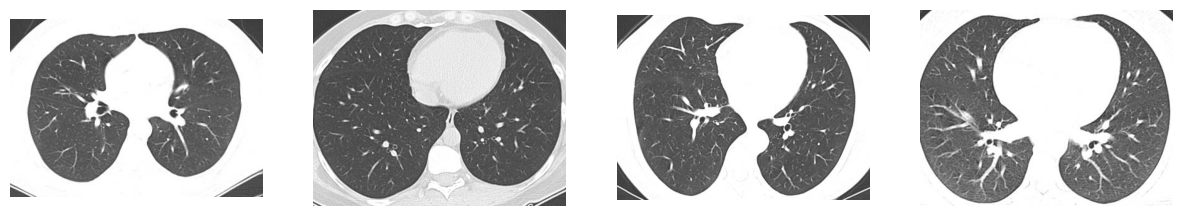

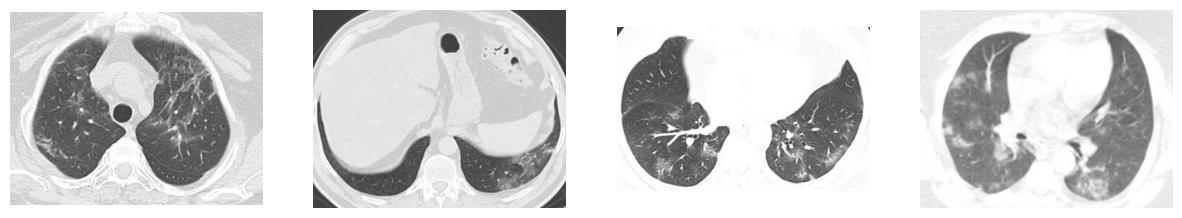

In [10]:
def plot_images_in_row(folder_path, num_images=4):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(15, 3))

    for i, image_file in enumerate(selected_images, start=1):
        plt.subplot(1, num_images, i)
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

covid_folder = './data/train/covid'
healthy_folder = './data/train/healthy'

plot_images_in_row(healthy_folder)
plot_images_in_row(covid_folder)

Create data loaders and apply preprocessing techniques, as well as augmentation and transformation methods, to enhance the model's performance. Also, split the data into train and test sets.

In [11]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

batch_size = 16

covid_train = os.listdir('./data/train/covid')
healthy_train = os.listdir('./data/train/healthy')

train_dataset = datasets.ImageFolder(root='./data/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='./data/test', transform=transform_test)

class_counts = [covid_train, healthy_train]
total_samples = sum(map(len, class_counts))
class_freq = [len(class_sample) / total_samples for class_sample in class_counts]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### ResNet

* Define your model here. You don't need to code it from scratch, and you can also utilize transfer learning if you believe it would enhance your model's performance.

* If a class imbalance problem exists, recommend a solution and implement it.

In [12]:
resnet_model = models.resnet18(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)
resnet_model = resnet_model.to(device)

class_weights = torch.FloatTensor([1.0 / freq for freq in class_freq]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.5MB/s]


In [13]:
def fit_model(epochs, model, criterion, optimizer, Train, Test):

    train_acc, train_loss = [], []
    test_acc, test_loss = [], []

    for epoch in range(epochs):
        epoch_acc, epoch_loss = 0, 0
        model = model.train()

        with tqdm.tqdm(enumerate(Train), total=len(Train)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                optimizer.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)
                epoch_acc += (pred.t() == labels).sum().item()

        train_loss.append(epoch_loss/(i+1))
        train_acc.append(epoch_acc/len(Train.dataset))

        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Train.dataset)))

        epoch_acc, epoch_loss = 0, 0
        model.eval()

        with tqdm.tqdm(enumerate(Test), total=len(Test)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = criterion(output, labels)

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)

                epoch_acc += (pred.t() == labels).sum().item()

        test_loss.append(epoch_loss/(i+1))
        test_acc.append(epoch_acc/len(Test.dataset))

        print('Epoch: %d | Loss: %.4f | Test Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Test.dataset)))

    return train_loss, train_acc, test_loss, test_acc


In [15]:
epochs = 20
train_loss , train_acc, test_loss, test_acc = fit_model(epochs, resnet_model,
                                                        criterion, optimizer,
                                                        train_loader, test_loader)

100%|██████████| 65/65 [00:12<00:00,  5.29it/s]

Epoch: 0 | Loss: 0.2491 | Train Accuracy: 0.8814



100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

Epoch: 0 | Loss: 0.1910 | Test Accuracy: 0.9261



100%|██████████| 65/65 [00:10<00:00,  5.99it/s]

Epoch: 1 | Loss: 0.0879 | Train Accuracy: 0.9709



100%|██████████| 17/17 [00:03<00:00,  5.10it/s]

Epoch: 1 | Loss: 0.0736 | Test Accuracy: 0.9678



100%|██████████| 65/65 [00:10<00:00,  6.17it/s]

Epoch: 2 | Loss: 0.0562 | Train Accuracy: 0.9768



100%|██████████| 17/17 [00:03<00:00,  5.22it/s]

Epoch: 2 | Loss: 0.3566 | Test Accuracy: 0.9034



100%|██████████| 65/65 [00:12<00:00,  5.35it/s]

Epoch: 3 | Loss: 0.0408 | Train Accuracy: 0.9879



100%|██████████| 17/17 [00:03<00:00,  4.82it/s]

Epoch: 3 | Loss: 0.0441 | Test Accuracy: 0.9848



100%|██████████| 65/65 [00:10<00:00,  6.20it/s]

Epoch: 4 | Loss: 0.0199 | Train Accuracy: 0.9923



100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

Epoch: 4 | Loss: 0.0741 | Test Accuracy: 0.9773



100%|██████████| 65/65 [00:11<00:00,  5.88it/s]

Epoch: 5 | Loss: 0.0342 | Train Accuracy: 0.9874



100%|██████████| 17/17 [00:02<00:00,  5.77it/s]

Epoch: 5 | Loss: 0.0443 | Test Accuracy: 0.9867



100%|██████████| 65/65 [00:11<00:00,  5.88it/s]

Epoch: 6 | Loss: 0.0175 | Train Accuracy: 0.9942



100%|██████████| 17/17 [00:02<00:00,  6.15it/s]

Epoch: 6 | Loss: 0.1553 | Test Accuracy: 0.9678



100%|██████████| 65/65 [00:11<00:00,  5.74it/s]

Epoch: 7 | Loss: 0.0189 | Train Accuracy: 0.9956



100%|██████████| 17/17 [00:02<00:00,  6.46it/s]

Epoch: 7 | Loss: 0.0531 | Test Accuracy: 0.9848



100%|██████████| 65/65 [00:11<00:00,  5.69it/s]

Epoch: 8 | Loss: 0.0091 | Train Accuracy: 0.9981



100%|██████████| 17/17 [00:02<00:00,  7.11it/s]

Epoch: 8 | Loss: 0.0819 | Test Accuracy: 0.9754



100%|██████████| 65/65 [00:11<00:00,  5.65it/s]

Epoch: 9 | Loss: 0.0051 | Train Accuracy: 0.9985



100%|██████████| 17/17 [00:02<00:00,  7.16it/s]

Epoch: 9 | Loss: 0.0716 | Test Accuracy: 0.9848



100%|██████████| 65/65 [00:11<00:00,  5.55it/s]

Epoch: 10 | Loss: 0.0063 | Train Accuracy: 0.9981



100%|██████████| 17/17 [00:02<00:00,  7.26it/s]

Epoch: 10 | Loss: 0.0289 | Test Accuracy: 0.9867



100%|██████████| 65/65 [00:11<00:00,  5.53it/s]

Epoch: 11 | Loss: 0.0019 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  7.16it/s]

Epoch: 11 | Loss: 0.0365 | Test Accuracy: 0.9886



100%|██████████| 65/65 [00:11<00:00,  5.52it/s]

Epoch: 12 | Loss: 0.0029 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  7.05it/s]

Epoch: 12 | Loss: 0.1163 | Test Accuracy: 0.9792



100%|██████████| 65/65 [00:11<00:00,  5.48it/s]

Epoch: 13 | Loss: 0.0254 | Train Accuracy: 0.9918



100%|██████████| 17/17 [00:02<00:00,  7.27it/s]

Epoch: 13 | Loss: 0.0774 | Test Accuracy: 0.9735



100%|██████████| 65/65 [00:11<00:00,  5.53it/s]

Epoch: 14 | Loss: 0.0154 | Train Accuracy: 0.9952



100%|██████████| 17/17 [00:02<00:00,  7.08it/s]

Epoch: 14 | Loss: 0.0757 | Test Accuracy: 0.9811



100%|██████████| 65/65 [00:12<00:00,  5.40it/s]

Epoch: 15 | Loss: 0.0513 | Train Accuracy: 0.9840



100%|██████████| 17/17 [00:02<00:00,  6.98it/s]

Epoch: 15 | Loss: 0.7371 | Test Accuracy: 0.8939



100%|██████████| 65/65 [00:11<00:00,  5.48it/s]

Epoch: 16 | Loss: 0.0479 | Train Accuracy: 0.9826



100%|██████████| 17/17 [00:02<00:00,  7.05it/s]

Epoch: 16 | Loss: 0.0394 | Test Accuracy: 0.9848



100%|██████████| 65/65 [00:11<00:00,  5.55it/s]

Epoch: 17 | Loss: 0.0176 | Train Accuracy: 0.9942



100%|██████████| 17/17 [00:02<00:00,  6.84it/s]

Epoch: 17 | Loss: 0.0365 | Test Accuracy: 0.9848



100%|██████████| 65/65 [00:11<00:00,  5.45it/s]

Epoch: 18 | Loss: 0.0038 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:02<00:00,  6.86it/s]

Epoch: 18 | Loss: 0.0184 | Test Accuracy: 0.9943



100%|██████████| 65/65 [00:11<00:00,  5.50it/s]

Epoch: 19 | Loss: 0.0024 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.80it/s]

Epoch: 19 | Loss: 0.0343 | Test Accuracy: 0.9848


Plot Accuracy and Loss plots for both training and validation parts.

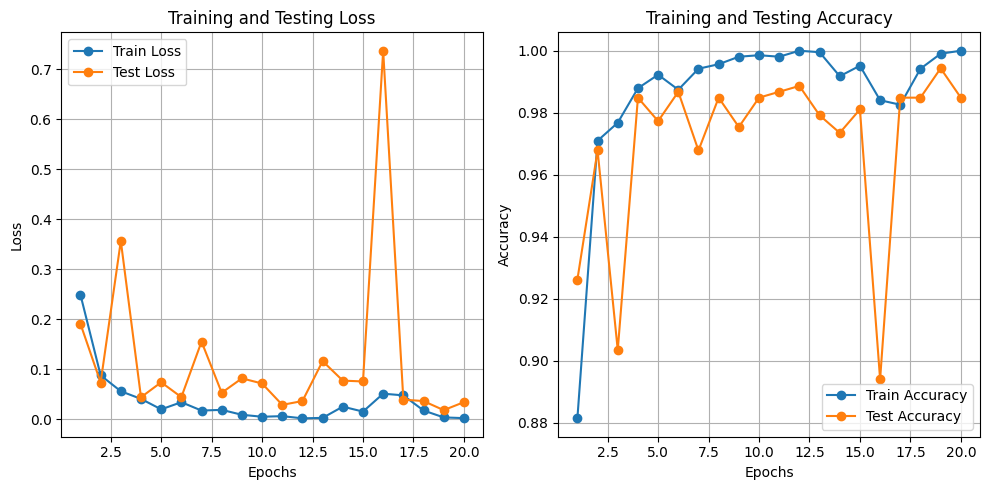

In [16]:
epochs = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='o')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Interpretability
Here, we aim to select an interpretability algorithm that aids in comprehending the model's decision-making process, debugging, and explaining predictions to non-technical stakeholders. Let's opt for the [Grad-CAM](https://arxiv.org/abs/1610.02391) technique. Grad-CAM, short for Gradient-weighted Class Activation Mapping, highlights important regions in an image that contribute to the model's prediction. This is achieved by computing the gradients of the target class with respect to the final convolutional layer. First, explain about this method and how it works, then implement this technique and visualize the resulting heatmaps.

[GradCam github](https://github.com/jacobgil/pytorch-grad-cam)

**Your Answer (10 points)**:

به طور کلی الگوریتم به شرح زیر است:

1 - The input image is passed through NN and activations are computed for each layer.

2 - The gradients of the predicted class score (has the most probabilty ) with respect to the feature maps of the last convolutional layer are computed. These gradients represent the importance of each feature map in the final prediction.

3- The gradient are spatialy averaged to obtain a weight for each feature map.

4 - The feature maps multiplied by their corresponding weights.

5 - Discard negative values

6 - The obtained heatmap combined with the oroginal feature maps ( last layer )

7 - Normalize heatmap

**GradCam usage (60 points)**:

In [17]:
'''
  Initially, it is crucial to ensure that the model is in Evaluation mode.
  Failing to do so during result verification could inadvertently alter the
  model's weights, leading to inaccurate and unreliable results.
'''
resnet_model.eval()
device = "cpu"
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Within this section, leverage GradCam to create a function that generates a plot for a given image address. The function should display the image and overlay a heatmap (which was generated by GradCam) on it in a separate plot. **For this, use the 4th layer of your trained Resent**.

In [18]:
class Hook():
    def __init__(self, name, module, backward=False):

        self.name = name

        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output

    def close(self):
        self.hook.remove()

hookF = [Hook(name, layer) for name, layer in resnet_model.named_modules()]
hookB = [Hook(name, layer,backward=True) for name, layer in resnet_model.named_modules()]

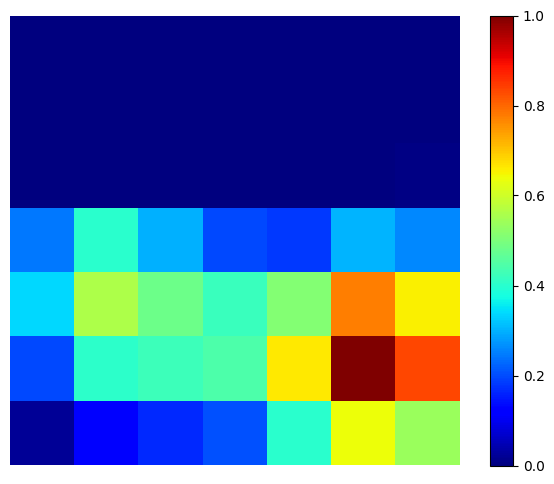

In [47]:

def plot_GradCam(image, plot=True, is_path=True):
    # TODO
    if is_path:
      image = Image.open(image)
      image = transform_test(image)

    with torch.enable_grad():
        output = resnet_model(image.unsqueeze(0))
        loss = output[0, torch.argmax(output)].backward()


    for hook in hookF:
        if hook.name == 'layer4.1.conv2':
            act = hook.output.detach()

    for hook in hookB:
        if hook.name == 'layer4.1.conv2':
            grad = hook.output[0].detach()



    pooled_grad = torch.mean(grad, dim=[0, 2, 3])
    for i in range(act.shape[1]):
        act[:, i, :, :] *= pooled_grad[i]
    heatmap = torch.sum(act, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().numpy(), 0)
    heatmap /= np.max(heatmap)

    # Visualize the raw CAM
    if plot:
      plt.imshow(heatmap, cmap='jet')
      plt.axis('off')
      plt.tight_layout()
      plt.colorbar()
      plt.show()

    return heatmap, image.squeeze(0).permute(2 , 1, 0).numpy()

h = plot_GradCam('/content/New_Data_CoV2/Covid/Patient/2.png')

Visualize GradCAM heatmaps for 10 images and interpret your model's performance and identify areas your model is paying attention to based on the GradCAM output. For this, use the function you wrote in the previous section.

In [77]:
# TODO
# -------------------------------- YOUR CODE --------------------------------
def show_predictions(img_paths, model, is_path):
    """
    Displays the first image of each of the num batches
    """
    images= []
    heat_maps = []
    masked_imgs = []
    for img in img_paths:
        heat_map, image = plot_GradCam(img, plot=False, is_path=is_path)
        mask_img = image.copy()
        heat_map = cv2.resize(heat_map, (224, 224))
        mask_img[:,:,0] = image[:,:,0] * (heat_map > 0.6)
        mask_img[:,:,1] = image[:,:,1] * (heat_map > 0.6)
        mask_img[:,:,2] = image[:,:,2] * (heat_map > 0.6)
        images.append(image); heat_maps.append(heat_map); masked_imgs.append(mask_img)

    fig, axes = plt.subplots(len(img_paths), 3, figsize=(10,30))

    for j in range(len(images)):

        axes[j, 0].imshow(images[j])
        axes[j, 0].axis('off')
        axes[j, 0].set_title('Image')

    for j in range(len(heat_maps)):
        axes[j, 1].imshow(heat_maps[j])
        axes[j, 1].axis('off')
        axes[j, 1].set_title('heat_map')

    for j in range(len(masked_imgs)):
        axes[j, 2].imshow(masked_imgs[j])
        axes[j, 2].axis('off')
        axes[j, 2].set_title('masked_img')


    plt.show()



# -------------------------------- YOUR CODE --------------------------------

In [32]:
img, _ = next(iter(test_loader))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


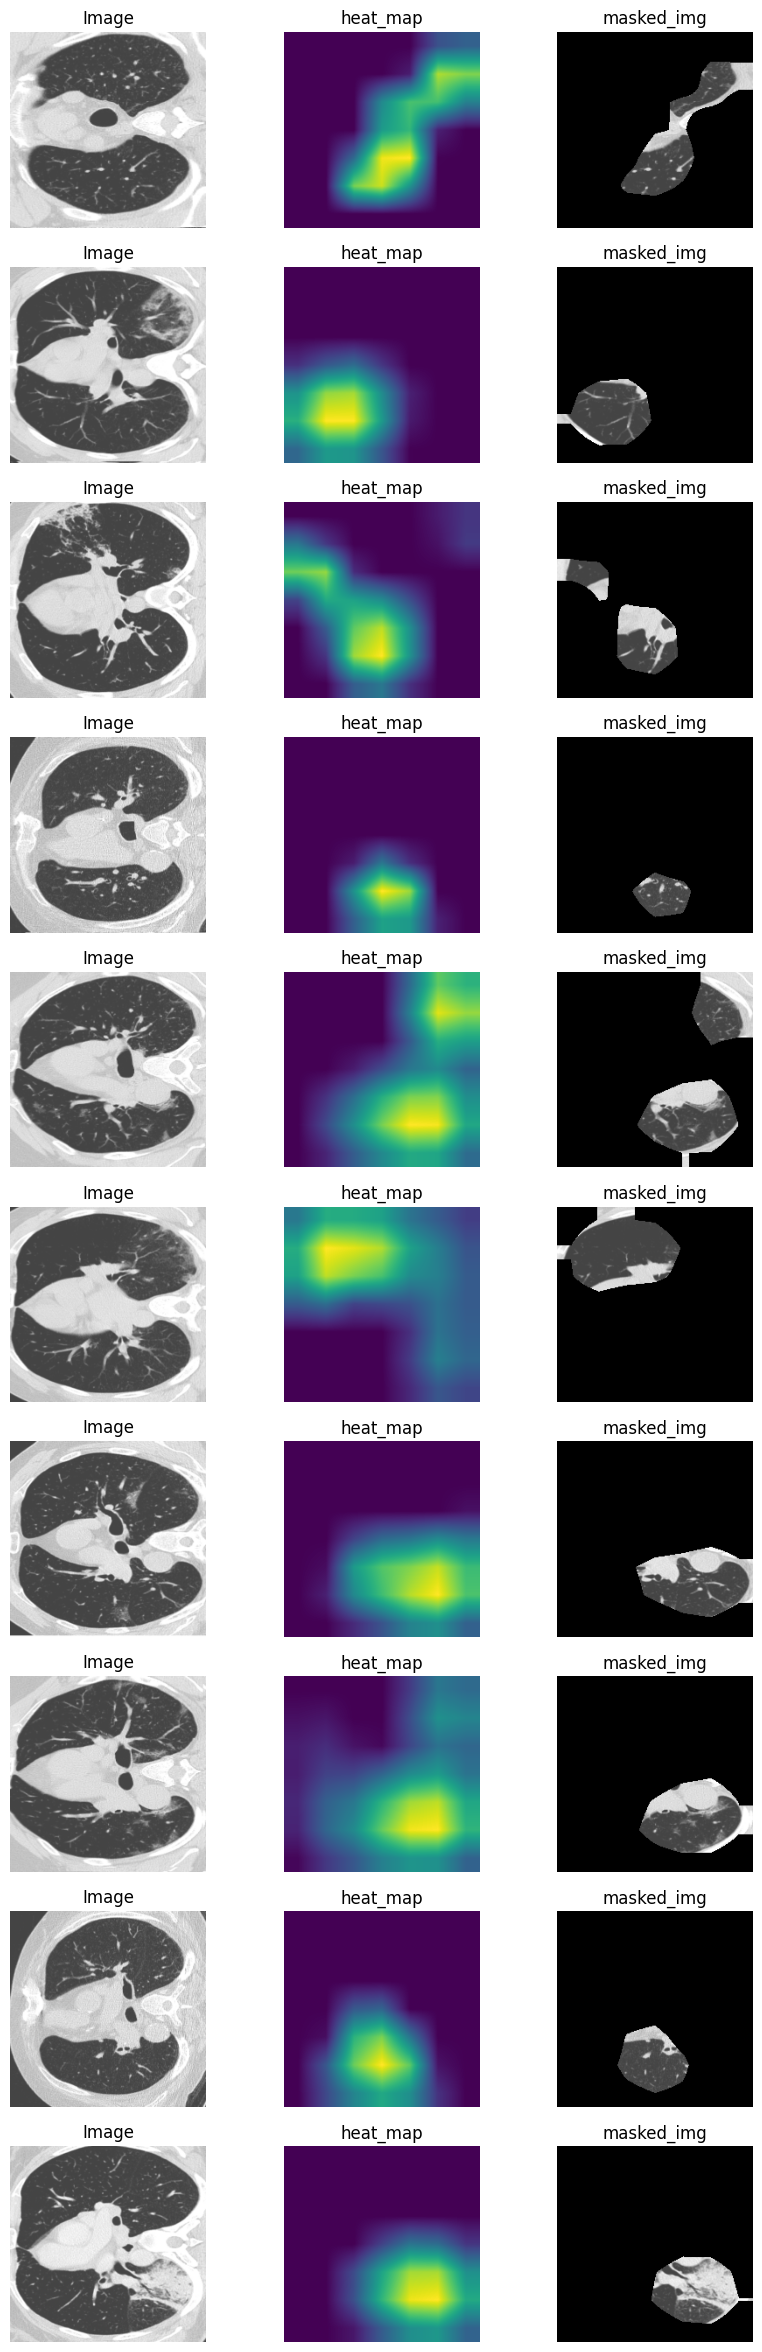

In [78]:
show_predictions(img[:10], resnet_model, is_path=False)

Now, envision that we have trained a neural network, obtained heatmaps, and achieved a model performance of 95%. Despite utilizing Grad-CAM, the heatmaps reveal a consistent focus on the corners, evident across numerous images. In your perspective, what could be the underlying problem, and how might we address and overcome this issue?

**Your Answer (10 points)**:

توجه کردن به نقاط خاصی از ممکن است از بایاس یا نامتعادل بودن دیتاست باشد که با اضافه کردن آگمنتیشن و یا دیگر تکنیک‌های رفع نامتعادل بودن دیتاست این مشکل را حل کرد.

...

تغییر معماری شبکه استفاده از مدل‌های پیش‌اموزش دیگر و یا تغییر هایپر پارامتر‌ها و استفاده از رگولاریزیشن و نرمالیزشین نیز کمک کننده‌است